In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

# 1 Data processing

In [5]:
# input LSOA.shp which contains factors
lsoa_gdf = gpd.read_file("./regression_data/nbregression_data_lsoa.shp")

Text(0.5, 0, 'SWI index')

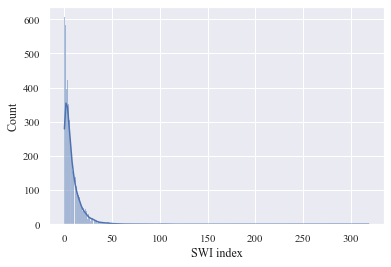

In [27]:
from pylab import mpl
sns.set_theme()
# set the font of graph
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'NSimSun,Times New Roman'

# plot distribution of SWI index
sns.histplot(data=lsoa_gdf.SWI,bins=350, x=lsoa_gdf.SWI, kde=True)
plt.xlabel('SWI index',fontsize=12, color='k')

Text(0.5, 0, 'SWI index')

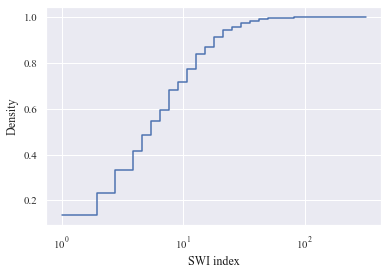

In [28]:
lsoa_wsi = lsoa_gdf[lsoa_gdf['SWI']!=0]

sns.histplot(
    data=lsoa_wsi, x=lsoa_wsi.SWI,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False
)
plt.xlabel('SWI index',fontsize=12, color='k')

In [74]:
# convert GeoDataFrame to DataFrame
regression_lsoa = pd.DataFrame(lsoa_wsi, columns = lsoa_wsi.columns.drop('geometry'))
# select the considered variables
regression_lsoa=regression_lsoa[[ 'SWI','INTERSECT', 'ACCOMM', 'EDU', 'IMD2019Ind','PARK', 'SHOP', 'TRANSPORT', 'WORK', 'ENTERTAIN',
                                   'ATTRACT', 'DENSITY_R', 'DEN_0_17', 'DEN_18_64', 'DEN_65']]

# 2. Data statistics

In [75]:
# define summary statistics
def SummaryStat(df):
    df_summary = df.describe().T
    df_summary['std'] = df.std()
    df_summary.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    return df_summary

In [76]:
SummaryStat(regression_lsoa)

,count,mean,std,min,25%,50%,75%,max
SWI,4229.0,9.090329,11.746550,1.000000,3.000000,6.000000,12.000000,319.000000
INTERSECT,4229.0,35.492551,25.016631,1.000000,21.000000,31.000000,44.000000,764.000000
ACCOMM,4229.0,0.397966,1.677895,0.000000,0.000000,0.000000,0.000000,53.000000
EDU,4229.0,2.610783,3.019150,0.000000,1.000000,2.000000,4.000000,77.000000
IMD2019Ind,4229.0,14908.926460,7941.855439,546.000000,8096.000000,13665.000000,21062.000000,32563.000000
PARK,4229.0,0.346181,0.983448,0.000000,0.000000,0.000000,0.000000,27.000000
SHOP,4229.0,11.406479,25.447417,0.000000,2.000000,5.000000,12.000000,759.000000
TRANSPORT,4229.0,4.723102,5.198945,0.000000,2.000000,4.000000,6.000000,140.000000
WORK,4229.0,31.859305,72.748864,0.000000,10.000000,17.000000,35.000000,3218.000000
ENTERTAIN,4229.0,2.803736,4.636480,0.000000,0.000000,2.000000,4.000000,118.000000


In [77]:
# Calculate the VIF for variables
def VIF(df,col):
    df = sm.add_constant(df)
    col.append('const')
    df_vif = df.loc[:,col]
    VIF=[variance_inflation_factor(np.matrix(df_vif),i) for i in range(len(col))]
    return pd.DataFrame({'variable':col,'VIF':VIF}).iloc[:-1]


In [78]:
variables = [ 'INTERSECT', 'ACCOMM', 'EDU', 'IMD2019Ind',
       'PARK', 'SHOP', 'TRANSPORT', 'WORK', 'ENTERTAIN',
       'ATTRACT', 'DENSITY_R', 'DEN_0_17', 'DEN_18_64', 'DEN_65']
VIF(regression_lsoa,variables)

,variable,VIF
0,INTERSECT,2.636266
1,ACCOMM,1.367804
2,EDU,2.069106
3,IMD2019Ind,1.283591
4,PARK,1.609835
5,SHOP,2.529426
6,TRANSPORT,2.668541
7,WORK,4.202290
8,ENTERTAIN,2.661822
9,ATTRACT,2.224922


In [79]:
# save data to csv.files for regression in Rstudio
regression_lsoa.to_csv('./regression_data/regression_data.csv', index=False)

# 3. Regression analysis

Please to see Rscrpit: Regression.R